In this notebook we train an hybrid autoencoder with a quantum circuit in the latent space

## imports

In [34]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import HAE as hae
from hep_VQAE import CAE as cae
from hep_VQAE import utils as ut
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

## data 

We use the 12x12 dataset and split it into test and train

In [3]:
test = h5py.File("../data/small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

seperate quarks from gluons and normalize the images

In [5]:
x_train_1 = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_1 = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_1 = x_test[y_test==1]
x_test = x_test[y_test==0]

In [6]:
div = np.max(x_train_1,axis=(1,2)).reshape(x_train_1.shape[0],1,1)
div[div == 0] = 1
x_train_1 = x_train_1 / div
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val_1,axis=(1,2)).reshape(x_val_1.shape[0],1,1)
div[div == 0] = 1
x_val_1 = x_val_1 / div
div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test_1,axis=(1,2)).reshape(x_test_1.shape[0],1,1)
div[div == 0] = 1
x_test_1 = x_test_1 / div
div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

reduce the dataset to reduce training time

In [7]:
x_train_small = x_train[:10000]
x_test_small = x_test[:1200]

x_train_1_small = x_train_1[:10000]
x_test_1_small = x_test_1[:1200]

## model

In this case we will input the 12x12 images. They will be reduced to 9x9 images by classical convolutional layers.

The 9x9 images are the input to the quantum circuit. They will be uploaded to the quantum circuit with a kernel size of 3 and a stride of 2.

Since ever upload occurs on one qubit, we have 3x3=9 gates per qubit and need 16 qubits in total.

In [17]:
latent_dim = 16
input_dim = 12
q_input_dim = 9

DRCs = 2

In [18]:
dev1 = qml.device('lightning.qubit', wires=latent_dim)

Create the hybrid model. 

In [20]:
model = hae.HybridAE(latent_dim=latent_dim,
                     input_dim=input_dim,
                     q_input_dim=q_input_dim,
                     DRCs=DRCs,
                     kernel_size=3,
                     stride=2,
                     device=dev1)

Now we can get a summary of the model (often the quantum layer parameters are marked as unused - this is a bug, but they are actually used and displayed correctly after the first forward pass)

In [26]:
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 9, 9, 12)          204       
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 10)          490       
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten_1 (Flatten)         (None, 81)                0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 16)                0 (unused)
                                                                 
 dense_1 (Dense)             (None, 81)                1377      
                                                                 
 reshape_1 (Reshape)         (None, 9, 9, 1)          

and plot the circuit

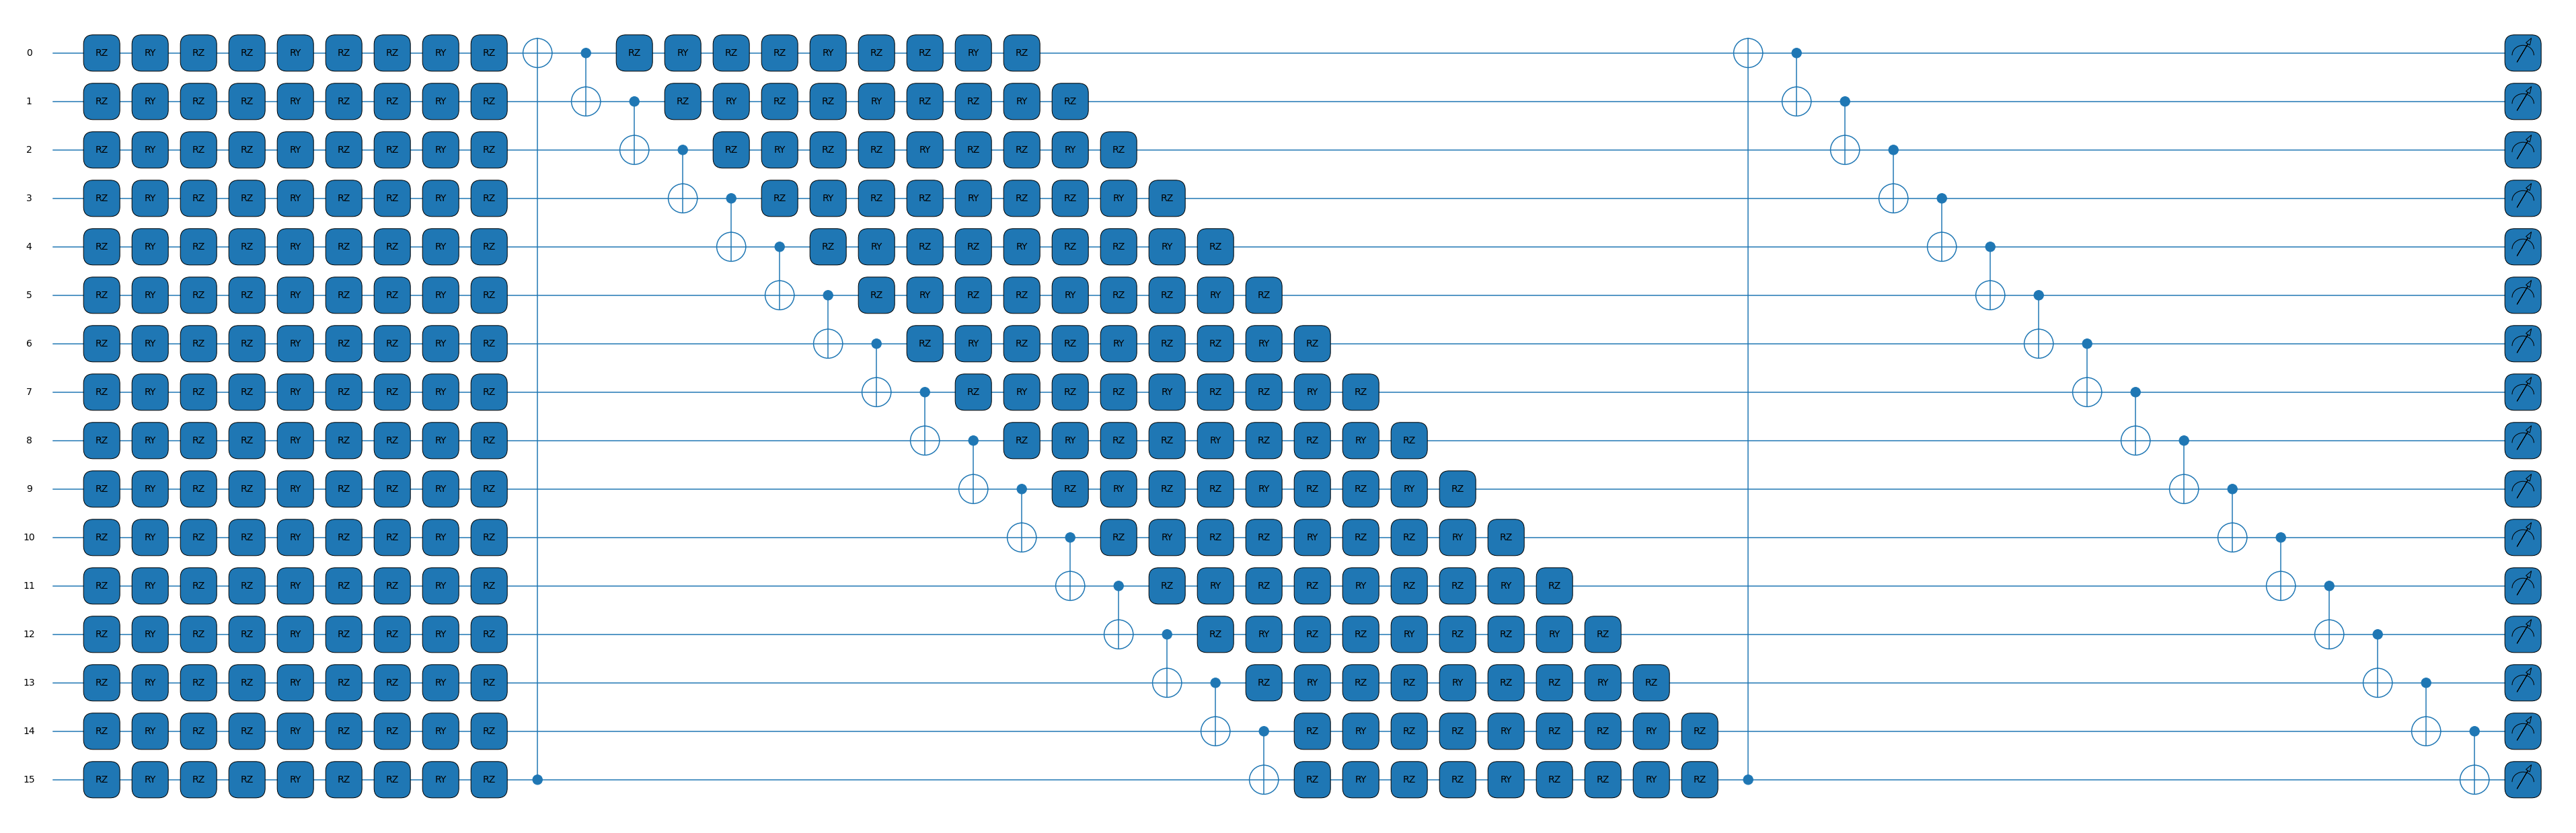

In [27]:
model.plot_circuit()

In [10]:
learning_rate = 0.0001
weight_decay = 0.00001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [11]:
model.compile(loss='binary_crossentropy', optimizer=optimizer)

We also use the callback to track the tagging performance during training.

In [12]:
auc_call = cae.AucCallback(model, x_test_1_small, x_test_small)

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=1e-5)
fitting = model.fit(x_train_1_small, x_train_1_small, 
                    epochs=20, 
                    batch_size=64, 
                    steps_per_epoch=100, 
                    validation_data=(x_test_1_small, x_test_1_small), 
                    callbacks=[es,auc_call])

Epoch 1/20



KeyboardInterrupt



In [30]:
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.yscale('log')

NameError: name 'fitting' is not defined

In [31]:
plt.plot(auc.history)

NameError: name 'auc' is not defined

In [36]:
recon = model.predict(x_test_1_small[:500])

ut.eval_recon(x_test_1_small[:500], recon, lognorm=True)


KeyboardInterrupt



In [37]:
recon = model.predict(x_test_1_small)
recon_sig = model.predict(x_test_small)

ut.eval_tagging(x_test_1_small, recon, x_test_small, recon_sig, lognorm=True)


KeyboardInterrupt

